# Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import randint
%matplotlib inline

# Preprocessing Libraries

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Model Libraries

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

***Loading dataset***

In [5]:
df = pd.read_csv('Crop_recommendation.csv')

In [6]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [8]:
df.shape

(2200, 8)

# DATA PREPROCESSING

In [10]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

***As there are no null values present in this dataset:
As an overview we first understand on which category the missing value falls "MCAR,MAR,NMAR,SM". And then use imputation techniques like mean,median for numberical data and mode for categorical data ,deleting a complete row will result in lose of information so its better to use imputation techniques. I use KNN, iterative imputation and and MICE dependent upon the category of missing value to get better results.***

In [11]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


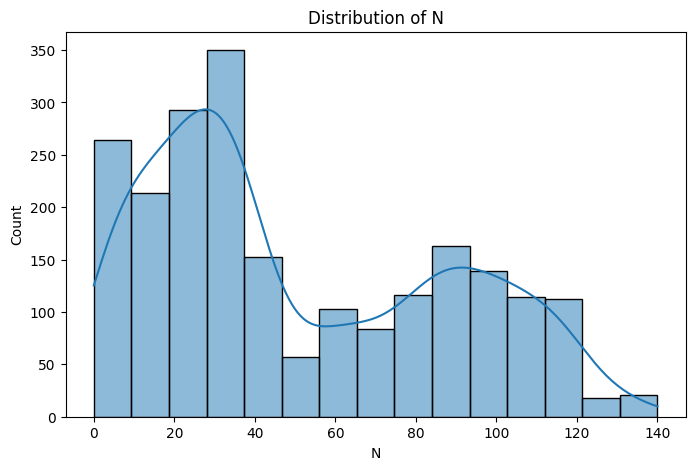

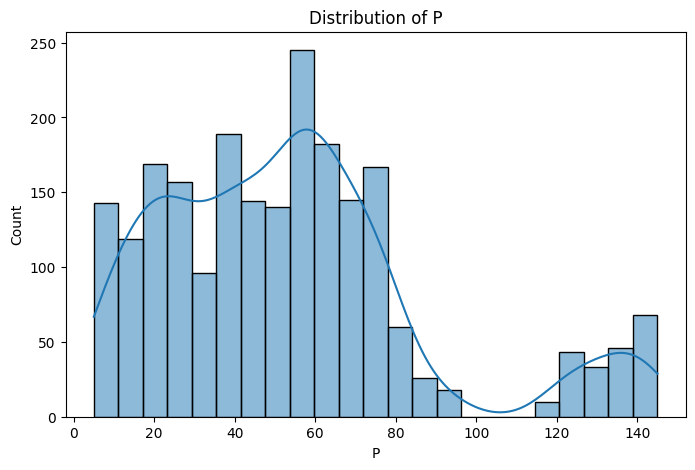

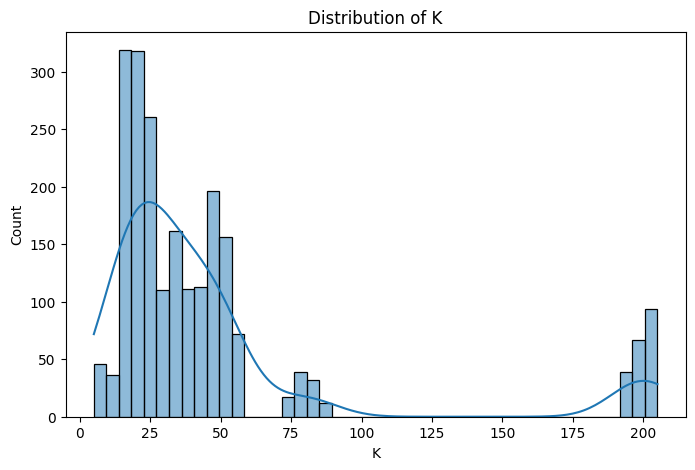

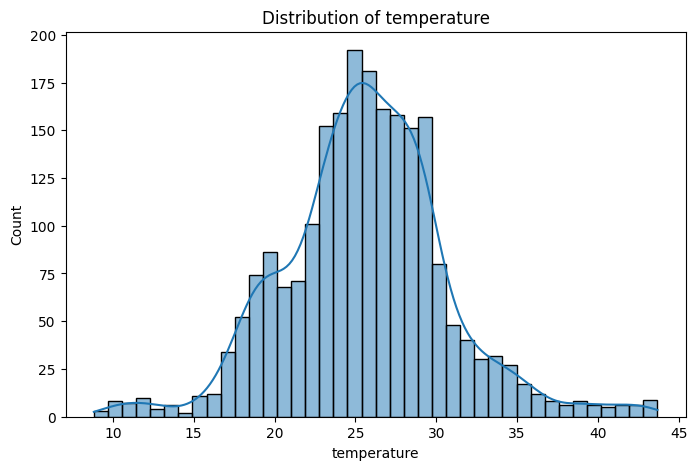

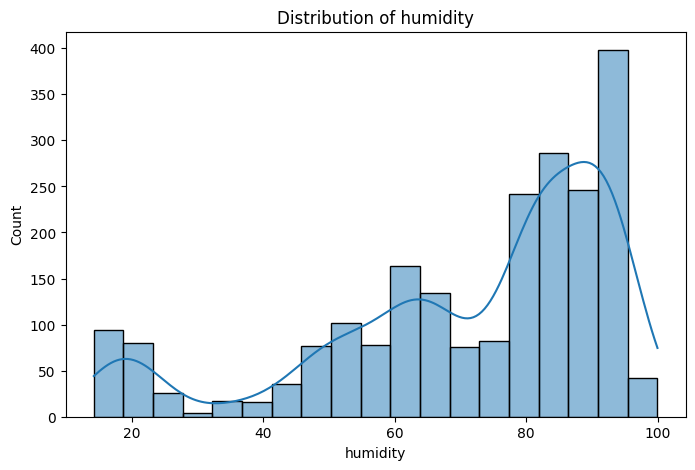

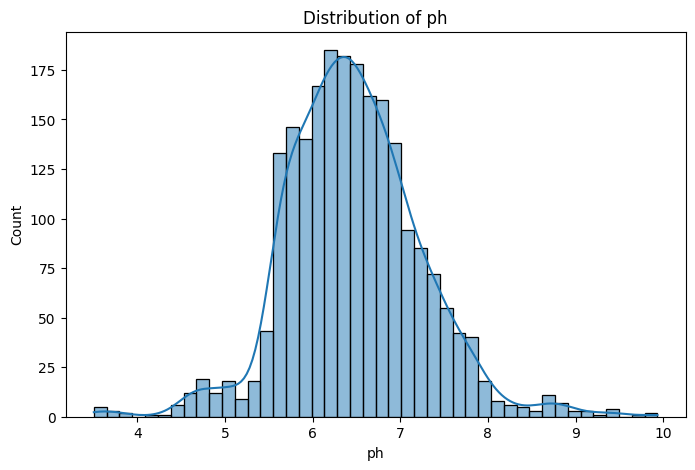

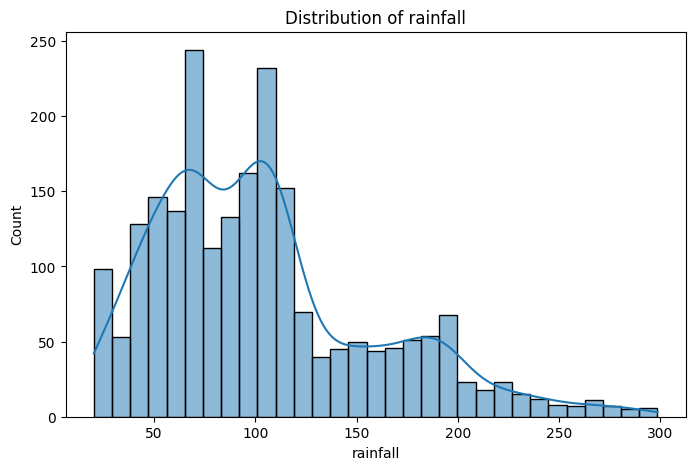

In [12]:
numeric_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

#Distribution of N,K,P,Humidity and rainfall are not normal distributed.

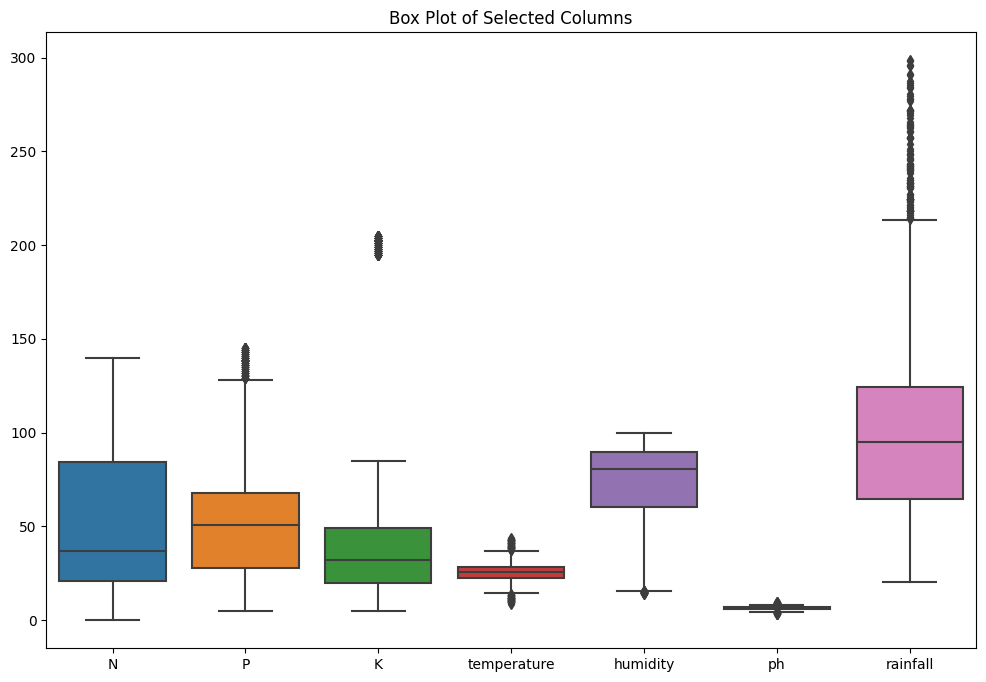

In [14]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.title('Box Plot of Selected Columns')
plt.show()

***As outliers are detected but according to the nature of the dataset climate conditions can go extreme sometime so its better to keep these extreme values. As an overview on how to deal with them outliers , AS the some of the columns are positively and negatively skewed so IQR will be used here to detect outliers then we will use capping or winsorization to deal with them. If normal distributed then we use z_score.***

In [61]:
#label Encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [18]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20


In [19]:
#Scaling
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [20]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,1.068797,-0.344551,-0.101688,-0.935587,0.472666,0.043302,1.810361,20
1,0.933329,0.140616,-0.141185,-0.759646,0.397051,0.734873,2.242058,20
2,0.255986,0.049647,-0.081939,-0.515898,0.486954,1.771510,2.921066,20
3,0.635298,-0.556811,-0.160933,0.172807,0.389805,0.660308,2.537048,20
4,0.743673,-0.344551,-0.121436,-1.083647,0.454792,1.497868,2.898373,20


# EDA

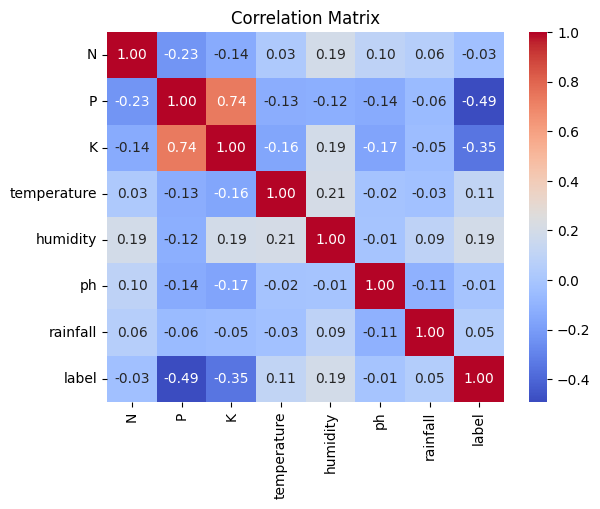

In [22]:
correlation_matrix = df[numeric_features + ['label']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

***corellation shows that P & K have more effect on labels then others. Temp and humidity have a connection if temp increases the humidity increases too.***

***So doing a Bivariate analysis on P,K,Temperature and Humidity to see how they are related with Label and with each other.***

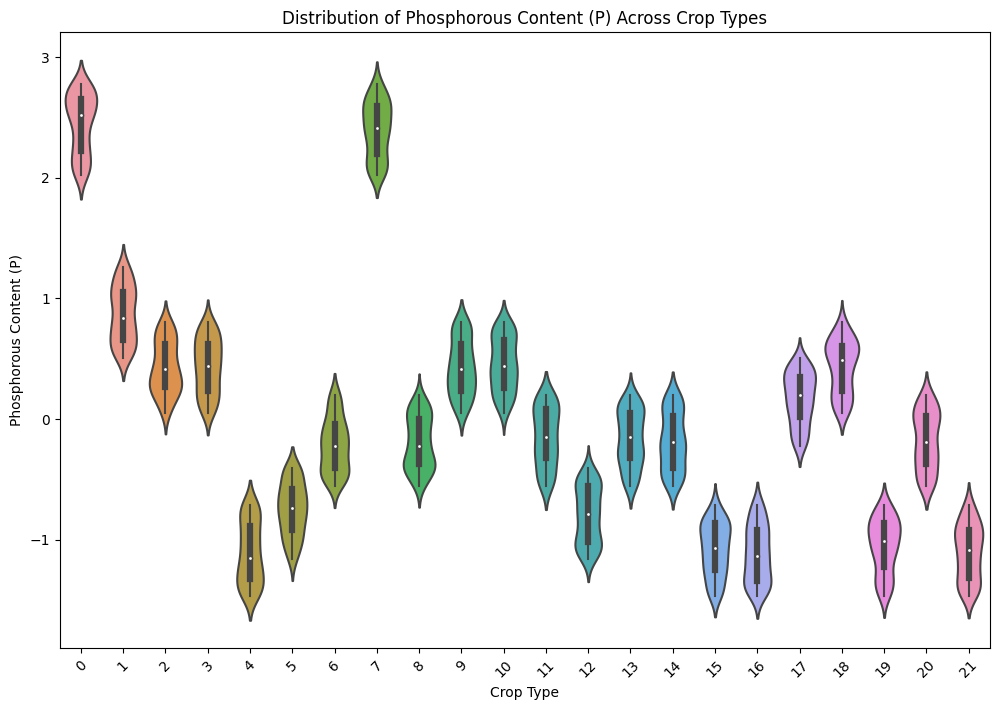

In [25]:
# --P--
plt.figure(figsize=(12, 8))
sns.violinplot(x='label', y='P', data=df)
plt.title('Distribution of Phosphorous Content (P) Across Crop Types')
plt.xlabel('Crop Type')
plt.ylabel('Phosphorous Content (P)')
plt.xticks(rotation=45) 
plt.show()

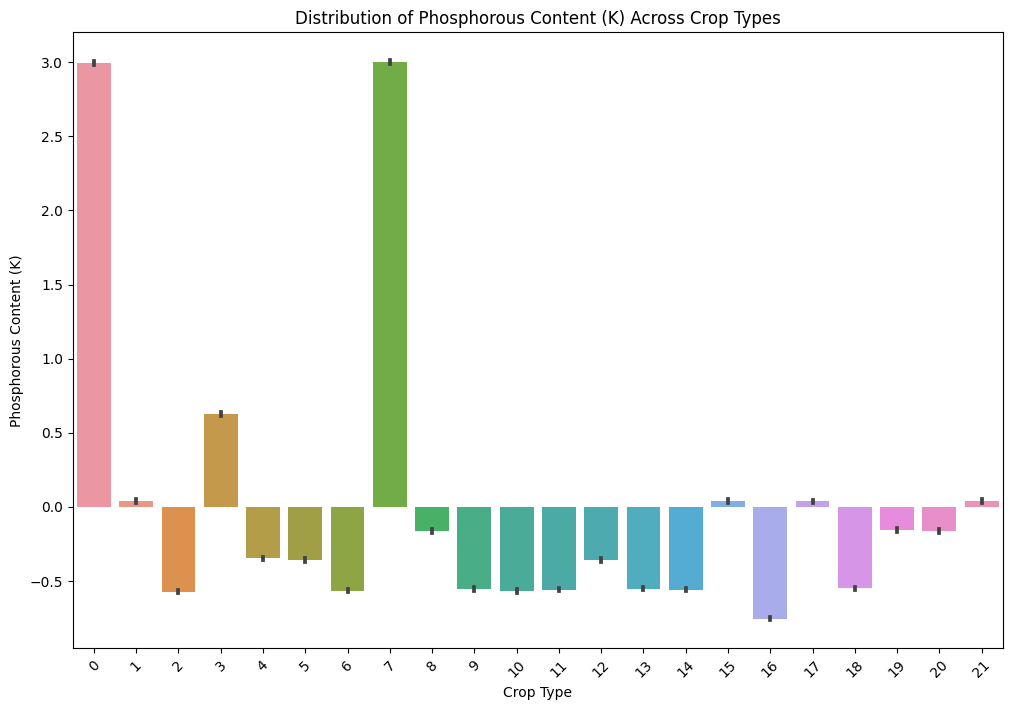

In [26]:
# --K--
plt.figure(figsize=(12, 8))
sns.barplot(x='label', y='K', data=df)
plt.title('Distribution of Phosphorous Content (K) Across Crop Types')
plt.xlabel('Crop Type')
plt.ylabel('Phosphorous Content (K)')
plt.xticks(rotation=45) 
plt.show()

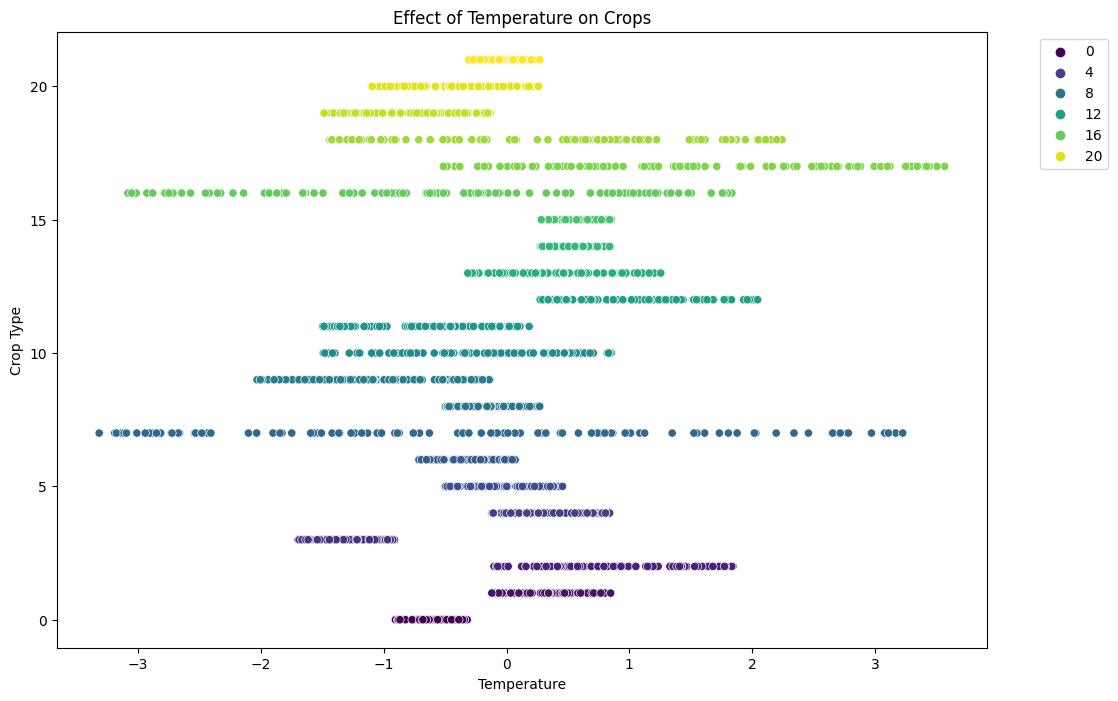

In [27]:
# Scatter plot for 'temperature' and 'label'
plt.figure(figsize=(12, 8))
sns.scatterplot(x='temperature', y='label', data=df, hue='label', palette='viridis')
plt.title('Effect of Temperature on Crops')
plt.xlabel('Temperature')
plt.ylabel('Crop Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

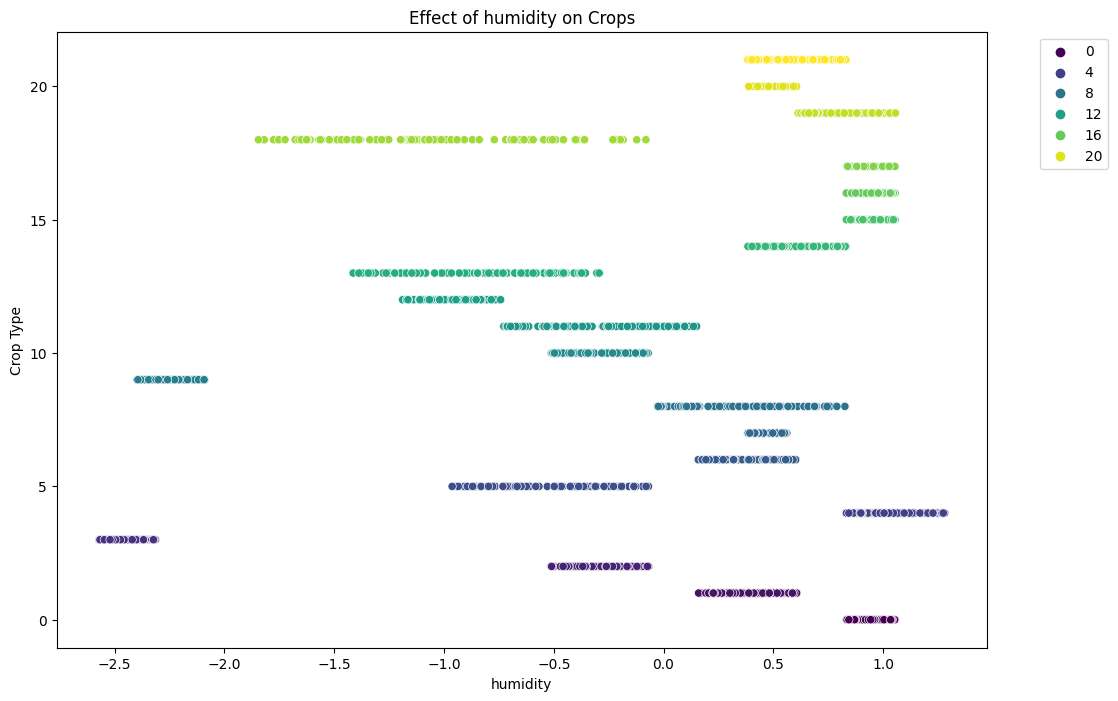

In [28]:
# Scatter plot for 'humidity' and 'label'
plt.figure(figsize=(12, 8))
sns.scatterplot(x='humidity', y='label', data=df, hue='label', palette='viridis')
plt.title('Effect of humidity on Crops')
plt.xlabel('humidity')
plt.ylabel('Crop Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

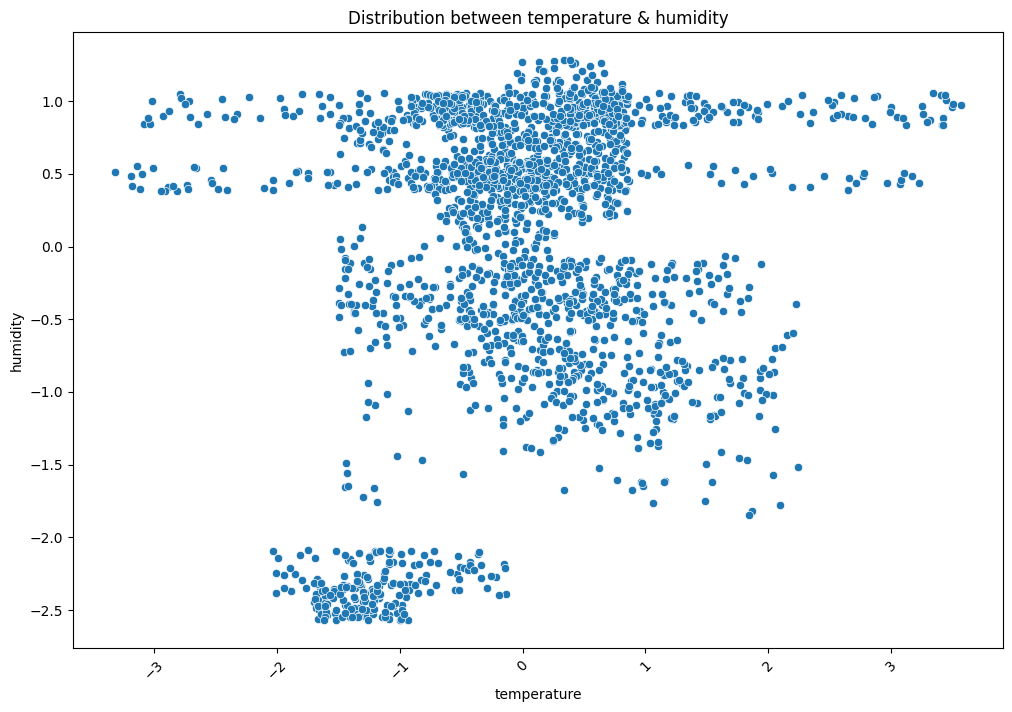

In [29]:
# temperature & humidity
plt.figure(figsize=(12, 8))
sns.scatterplot(x='temperature', y='humidity', data=df)
plt.title('Distribution between temperature & humidity')
plt.xlabel('temperature')
plt.ylabel('humidity')
plt.xticks(rotation=45) 
plt.show()

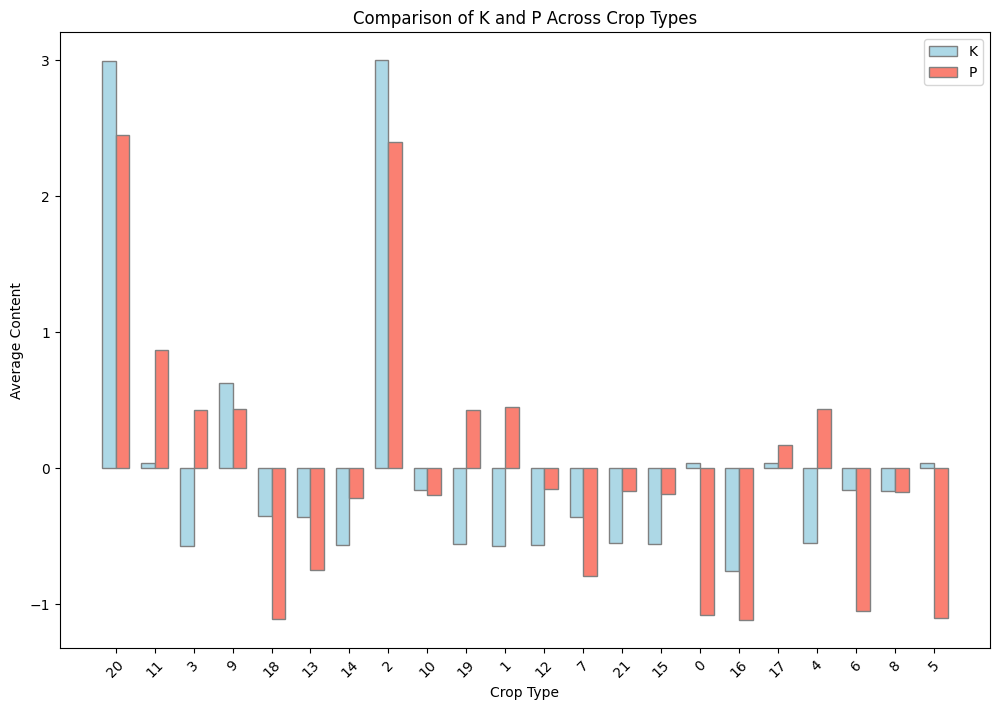

In [30]:
# --k,p and label
avg_k = df.groupby('label')['K'].mean()
avg_p = df.groupby('label')['P'].mean()

crop_types = df['label'].unique()

bar_width = 0.35

r1 = np.arange(len(crop_types))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 8))
plt.bar(r1, avg_k, color='lightblue', width=bar_width, edgecolor='grey', label='K')
plt.bar(r2, avg_p, color='salmon', width=bar_width, edgecolor='grey', label='P')
plt.xlabel('Crop Type')
plt.xticks([r + bar_width/2 for r in range(len(crop_types))], crop_types, rotation=45)
plt.ylabel('Average Content')
plt.title('Comparison of K and P Across Crop Types')
plt.legend()
plt.show()

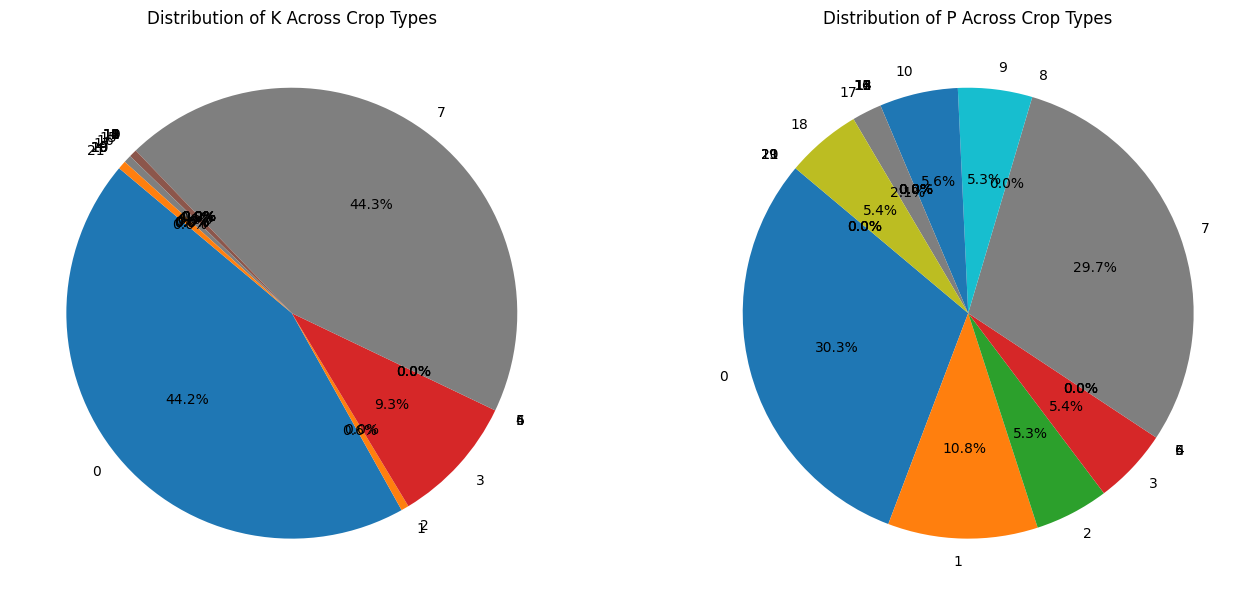

In [31]:
# Calculate average 'K' values for each crop type
avg_k = df.groupby('label')['K'].mean().clip(lower=0)
avg_p = df.groupby('label')['P'].mean().clip(lower=0)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].pie(avg_k, labels=avg_k.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of K Across Crop Types')
axs[1].pie(avg_p, labels=avg_p.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Distribution of P Across Crop Types')
plt.show()

# Model Building

***feature & target variables***

In [33]:
x = df.drop('label', axis=1)
y = df['label']

***splitting dataset***

In [35]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

***model***

In [126]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier()
}

In [132]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy for {name}: {accuracy*100}")
    print(f"\nClassification Report for {name}:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix for {name}:\n{confusion_matrix(y_test, y_pred)}")

Training Decision Tree...

Accuracy for Decision Tree: 98.63636363636363

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        26
           4       0.96      1.00      0.98        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      0.96      0.94        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      0.95      0.98        21
          12       1.00      1.00      1.00        19
          13       1.00      0.92      0.96        24
          14       1.00      1.00      1.00        19
          15       1

C:\Users\Hp\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***Choosing 'Random Forest' as it has the highest accuracy***

In [37]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_rf}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9931818181818182
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          16       1.00      

***As confusion matrix shows that there are only two instances where actual value was 20 and the predicted value is 8. But further checking for imbalance or overfitting.***

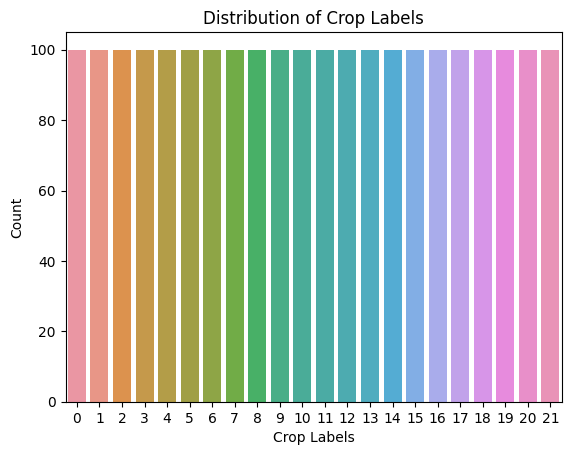

In [38]:
# checking for imbalance
sns.countplot(x='label', data=df)
plt.xlabel('Crop Labels')
plt.ylabel('Count')
plt.title('Distribution of Crop Labels')
plt.show()

In [40]:
# checking for overfitting
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=4)
print(f'Cross-Validation Scores: {cv_scores}')

Cross-Validation Scores: [0.98863636 0.99318182 0.99545455 0.99772727]


***As all the labels are equally balanced which shows that the dataset is not imbalanced. And for the OVERFITTING the validation scores are similar not that much difference which indicate that the model is not overfit***..

# Hyperperameter tuning

In [58]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, n_iter=1, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'bootstrap': True, 'max_depth': 38, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}


In [60]:
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the final model: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy of the final model: 0.9954545454545455
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        17
          